### 0. Loading requirements

In [1]:
import dataframe_image as dfi
import datasets
import interpret.glassbox
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import scipy as sp
from scraper import *
import seaborn as sns
import shap
import sklearn
from sklearn.preprocessing import OneHotEncoder
import xgboost

### 1. Summary Statistics and Visualizations

Getting summary statistics for metric and categorical variables.

In [2]:
# Importing csv file with the data
data = pd.read_csv("Product_Table_complete.csv")

In [3]:
# Get dimension of the dataset
print(data.shape)

(1687, 48)


In [4]:
# Generating a dataframe with all metric variables
metric_variables = get_metric_variables(data)
# Generating a dataframe with all categorical variables
categorical_variables = get_categorical_variables(data)
# Calculating summary statistics for all metric variables
metric_variables_summary = get_metric_variables_summary(metric_variables)
# Save them as a png
saving_table_as_png(metric_variables_summary, 'metric_variables_table.png')
# Generating a dictionary with summary statistics for every categorical feature
categorical_variables_summary = get_categorical_variables_summary(categorical_variables)
# Save summary for features "online-retailer", "brand" and "processor manufacturer" as png
saving_table_as_png(categorical_variables_summary['online-retailer'], 'online-retailer_table.png')
saving_table_as_png(categorical_variables_summary['brand'][0:5], 'brand_table.png')
saving_table_as_png(categorical_variables_summary['processor manufacturer'][0:5], 'processor_table.png')
# Correlation matrix for metric variables
correlation_matrix = metric_variables.corr()
display(metric_variables_summary)
display(categorical_variables_summary['online-retailer'])
display(categorical_variables_summary['brand'][0:5])
display(categorical_variables_summary['processor manufacturer'][0:5])

Create one chart with statistics comparing the three retailers. Getting average price of products, number of products. Brand with number of products that is sold the most.

In [5]:
# Group by online-retailer and calculate average price and most supplied brands and colours
retailer_table = get_online_retailer_comparison_table(data)
# Saving the table as png
saving_table_as_png(retailer_table, 'online_retailer_comp.png')

Bar Plots for the variables brand and colour are created to compared the counts between the two online-retailers.

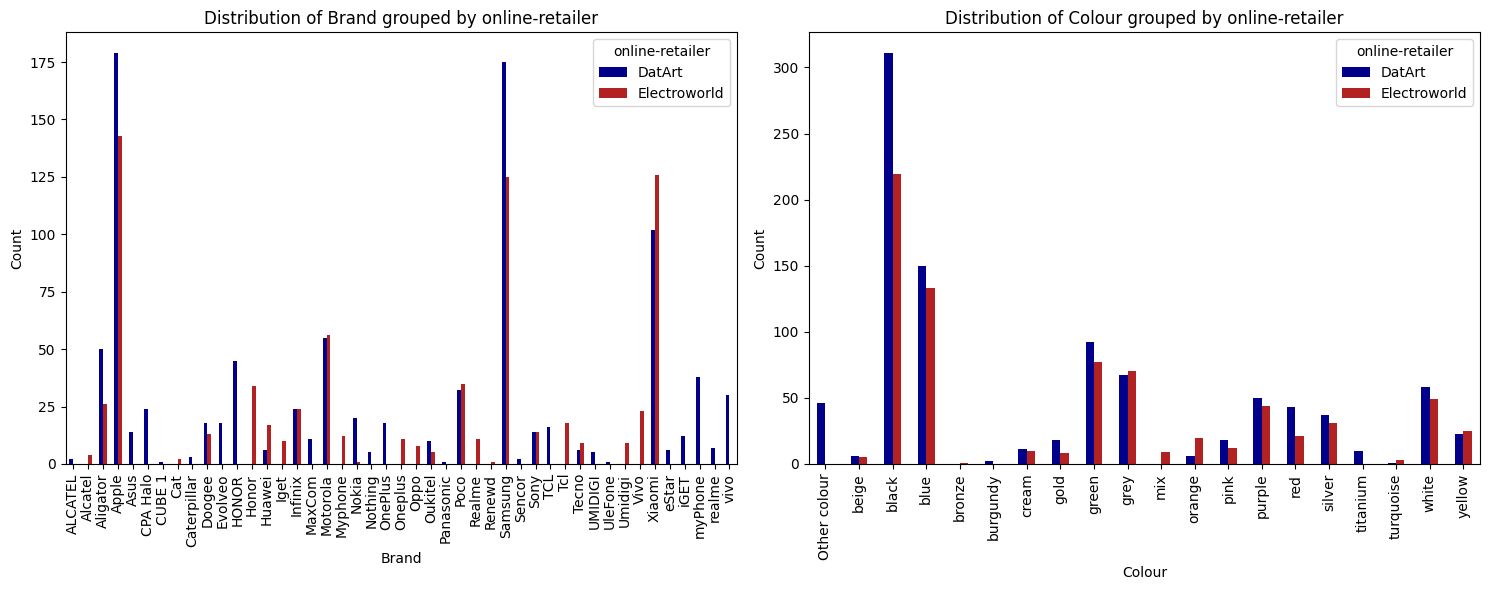

In [6]:
# List of variables to plot
variables_to_plot = ['brand', 'colour']
grouping_variable = 'online-retailer'  # Secondary variable for grouping

# Create a 2x2 subplot grid
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# Define colors for specific retailers
colors = {'Electroworld': 'firebrick', 'DatArt': 'darkblue'}

# Plot grouped bar chart for each variable
for idx, variable in enumerate(variables_to_plot):
    ax = axes[idx]  # Get the current axis
    grouped_data = data.groupby([variable, grouping_variable]).size().unstack()

    # Plot the grouped bar charts
    grouped_data.plot(kind='bar', ax=ax, color=[colors.get(c, 'grey') for c in grouped_data.columns])
    ax.set_title(f'Distribution of {variable.capitalize()} grouped by {grouping_variable}')
    ax.set_xlabel(variable.capitalize())
    ax.set_ylabel('Count')

# Adjust layout
plt.tight_layout()
# Saving plot in current wd in the "images" directory 
saving_plot("bar_plots_grouped.png")

Pie Plots for the variables connector and wireless charging are created to analyze the shares of both variables on the complete data.

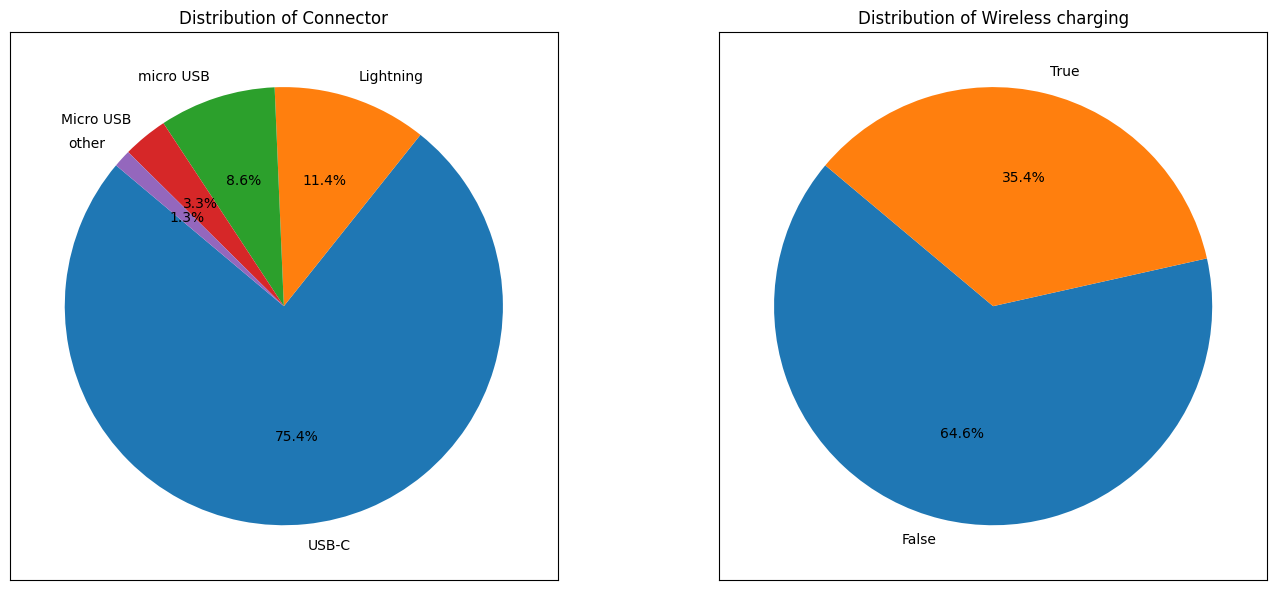

In [7]:
# List of variables to plot
variables_to_plot = ['connector', 'wireless charging']

# Set seaborn style and color palette
color_palette = sns.color_palette("tab10")

# Create a 1x2 subplot grid
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# Plot pie chart with percentages for each variable
for idx, variable in enumerate(variables_to_plot[:2]):  # Plot only the first two variables
    ax = axes[idx]  # Get the current axis
    category_counts = data[variable].value_counts()
    category_percentages = (category_counts / category_counts.sum()) * 100
    pie = category_percentages.plot(kind='pie', autopct='%1.1f%%', startangle=140, ax=ax, colors=color_palette)
    ax.set_title(f'Distribution of {variable.capitalize()}')
    ax.set_ylabel('')

    # Add frame
    ax.set_frame_on(True)

# Adjust layout
plt.tight_layout()

saving_plot("pie_plots.png")

The variables rear cam resolution and volume are plotted against the price variable and points are highlighted in colours, representing the online-retailer.

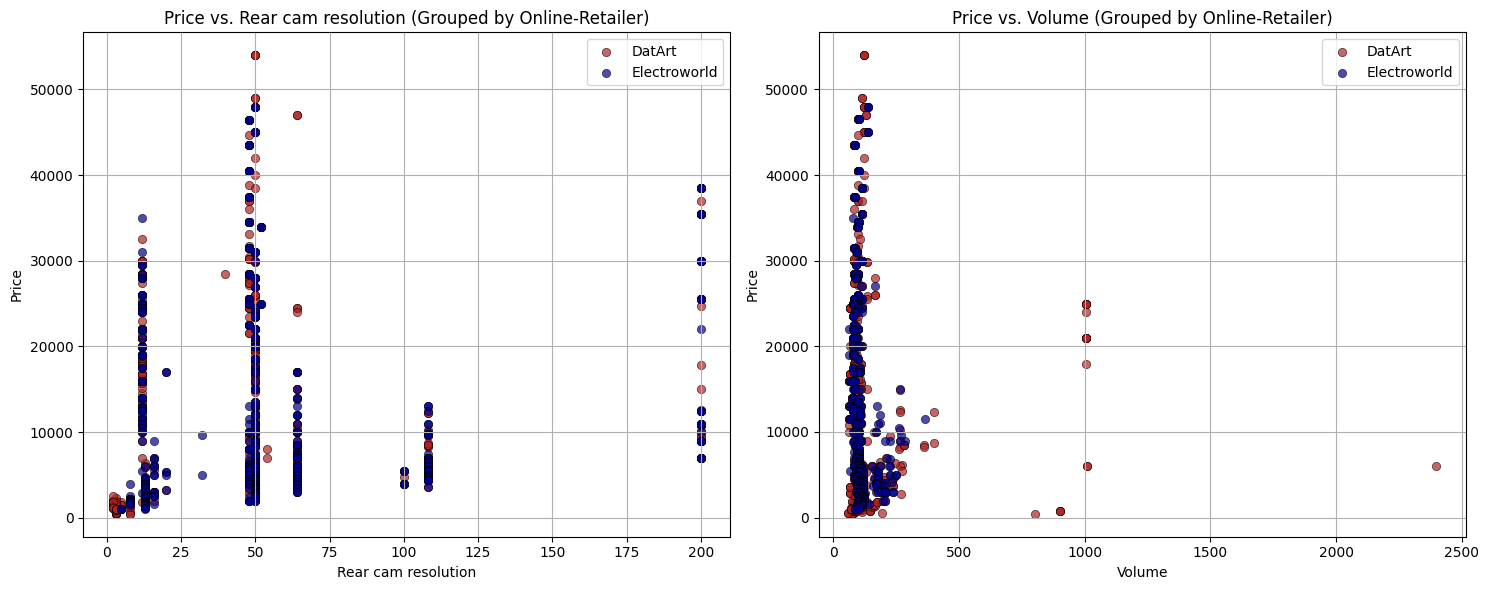

In [8]:
# List of variables to plot
variables_to_plot = ['rear cam resolution', 'volume']
online_retailer = ['DatArt', 'Electroworld']

# Create a 2x2 subplot grid
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# Define colors for each online retailer
retailer_colors = {'DatArt': 'firebrick', 'Electroworld': 'darkblue'}

# Plot scatter plot for each variable
for idx, variable in enumerate(variables_to_plot):
    ax = axes[idx]# Get the current axis
    
    # Plot scatter plot for each online retailer
    for retailer in online_retailer:
        subset_data = data[data['online-retailer'] == retailer]
        ax.scatter(subset_data[variable], subset_data['price'], c=retailer_colors[retailer], label=retailer, alpha=0.7, edgecolors='black', linewidth=0.5)
        
    ax.set_title(f'Price vs. {variable.capitalize()} (Grouped by Online-Retailer)')
    ax.set_xlabel(variable.capitalize())
    ax.set_ylabel('Price')
    ax.legend()
    ax.grid(True)

# Adjust layout
plt.tight_layout()

saving_plot("scatter_plots_retailer.png")

The variables display size and total resolution in pixels are plotted against the price variable and points are highlighted in colours, representing the phone brand.

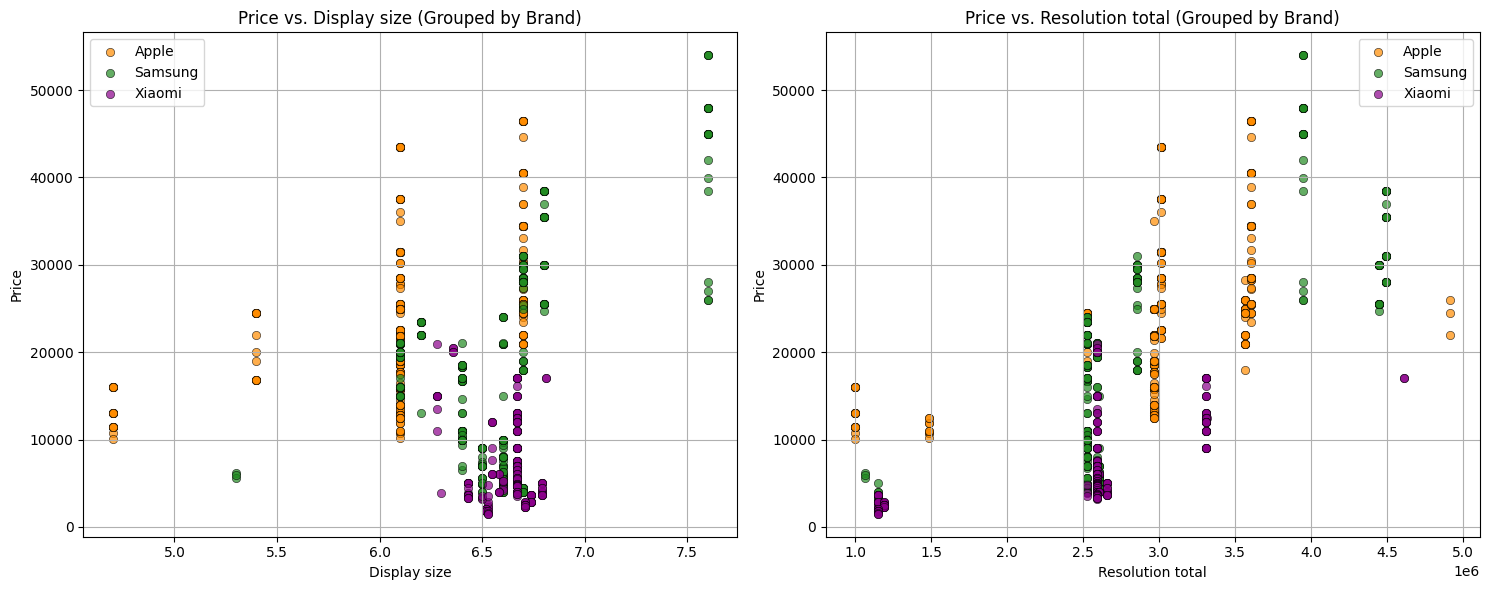

In [9]:
# List of variables to plot
variables_to_plot = ['display size', 'resolution total']
brands = ['Apple', 'Samsung', 'Xiaomi']

# Create a 2x2 subplot grid
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# Define colors for each online retailer
brands_colors = {'Apple': 'darkorange', 'Samsung': 'forestgreen', 'Xiaomi': 'darkmagenta'}

# Plot scatter plot for each variable
for idx, variable in enumerate(variables_to_plot):
    ax = axes[idx]  # Get the current axis
    
    # Plot scatter plot for each online retailer
    for brand in brands:
        subset_data = data[data['brand'] == brand]
        ax.scatter(subset_data[variable], subset_data['price'], c=brands_colors[brand], label=brand, alpha=0.7, edgecolors='black', linewidth=0.5)
        
    ax.set_title(f'Price vs. {variable.capitalize()} (Grouped by Brand)')
    ax.set_xlabel(variable.capitalize())
    ax.set_ylabel('Price')
    ax.legend()
    ax.grid(True)

# Adjust layout
plt.tight_layout()

saving_plot("scatter_plots_brand.png")

Histograms of the price variable grouped by phone brands are created.

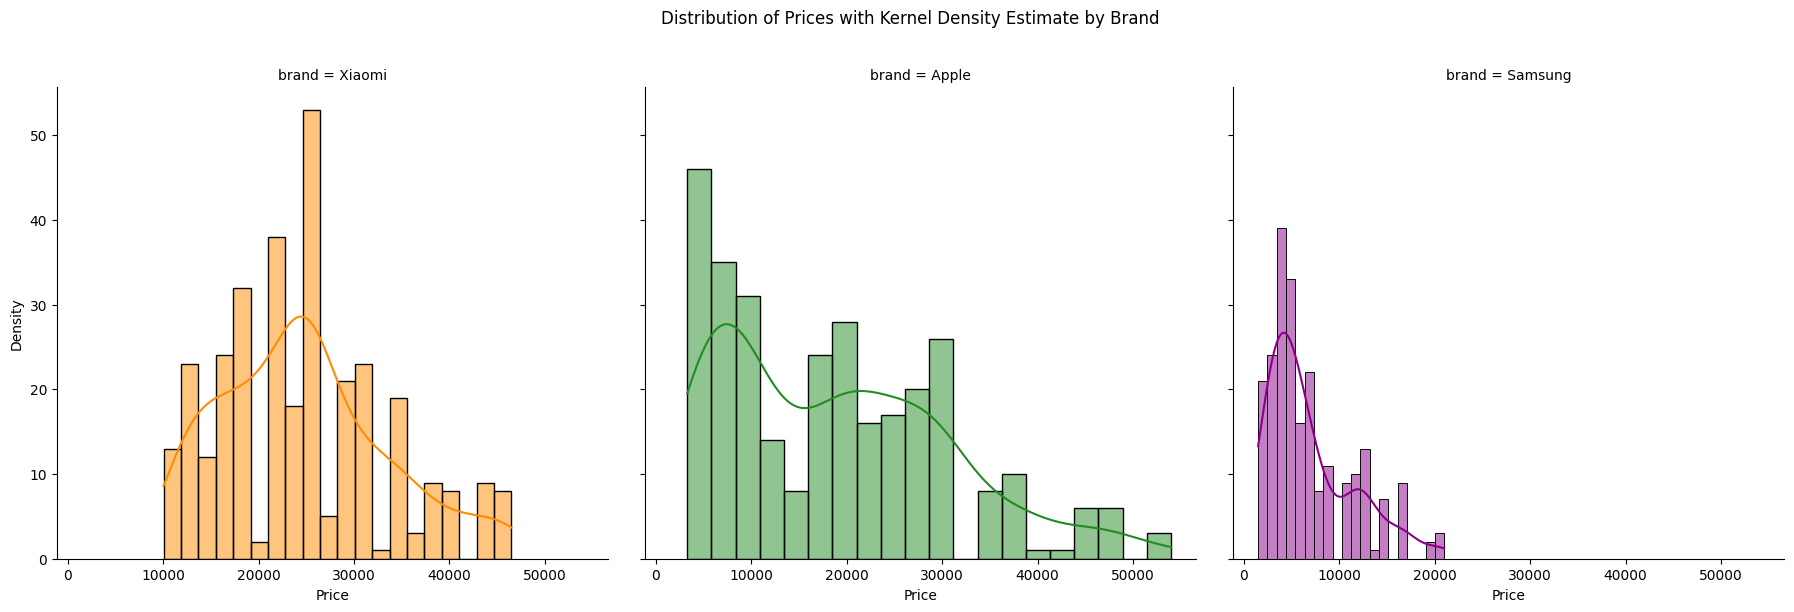

In [10]:
# Set up the FacetGrid
subset_data = data[data['brand'].isin(['Apple', 'Samsung', 'Xiaomi'])]

# Define custom colors for the brands
custom_palette = {'Apple': 'darkorange', 'Samsung': 'forestgreen', 'Xiaomi': 'darkmagenta'}

# Create the FacetGrid with custom palette
g = sns.FacetGrid(subset_data, col='brand', height=6)

# Plot histogram with KDE for each retailer
for brand, ax in zip(['Apple', 'Samsung', 'Xiaomi'], g.axes.flat):
    sns.histplot(subset_data[subset_data['brand'] == brand]['price'], 
                 bins=20, kde=True, edgecolor='black', color=custom_palette[brand], ax=ax)

# Add labels and title
g.set_axis_labels('Price', 'Density')
g.fig.subplots_adjust(top=0.85)
g.fig.suptitle('Distribution of Prices with Kernel Density Estimate by Brand')

saving_plot("histogram_grouped_brand.png")

Histograms of the price variable grouped by the online-retailers are created.

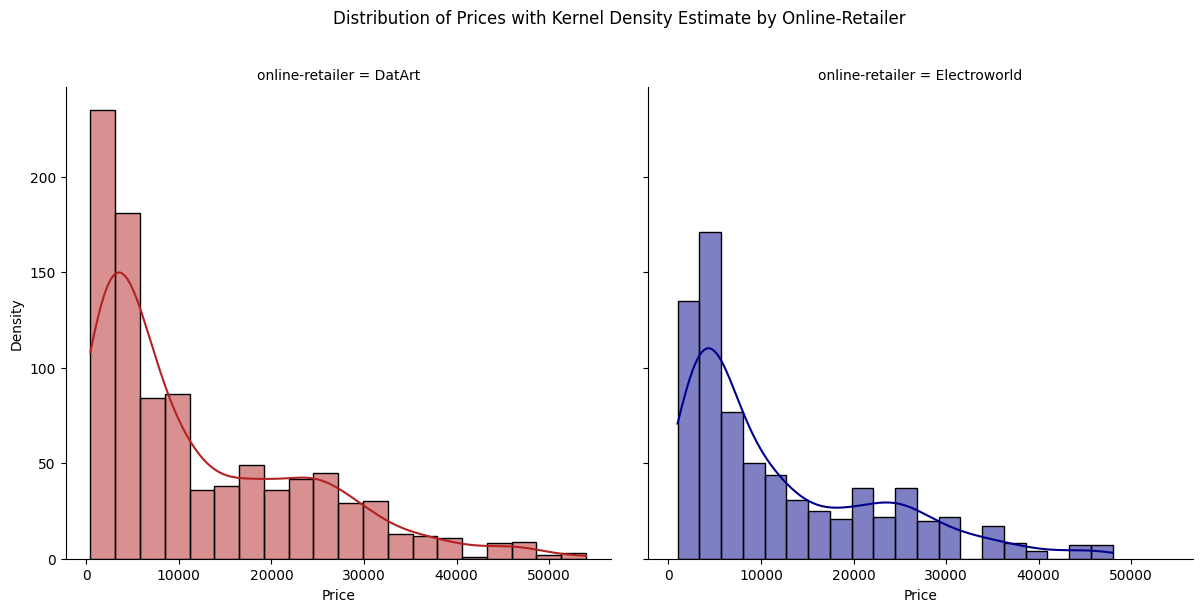

In [12]:
# Set up the FacetGrid
subset_data = data[data['online-retailer'].isin(['DatArt', 'Electroworld'])]

# Define custom colors for the brands
custom_palette = {'DatArt': 'firebrick', 'Electroworld': 'darkblue'}

# Create the FacetGrid with custom palette
g = sns.FacetGrid(subset_data, col='online-retailer', height=6)

# Plot histogram with KDE for each retailer
for online_retailer, ax in zip(['DatArt', 'Electroworld'], g.axes.flat):
    sns.histplot(subset_data[subset_data['online-retailer'] == online_retailer]['price'], 
                 bins=20, kde=True, edgecolor='black', color=custom_palette[online_retailer], ax=ax)

# Add labels and title
g.set_axis_labels('Price', 'Density')
g.fig.subplots_adjust(top=0.85)
g.fig.suptitle('Distribution of Prices with Kernel Density Estimate by Online-Retailer')

saving_plot("histogram_grouped_retailer.png")

For all metric variables a heatmap is created.

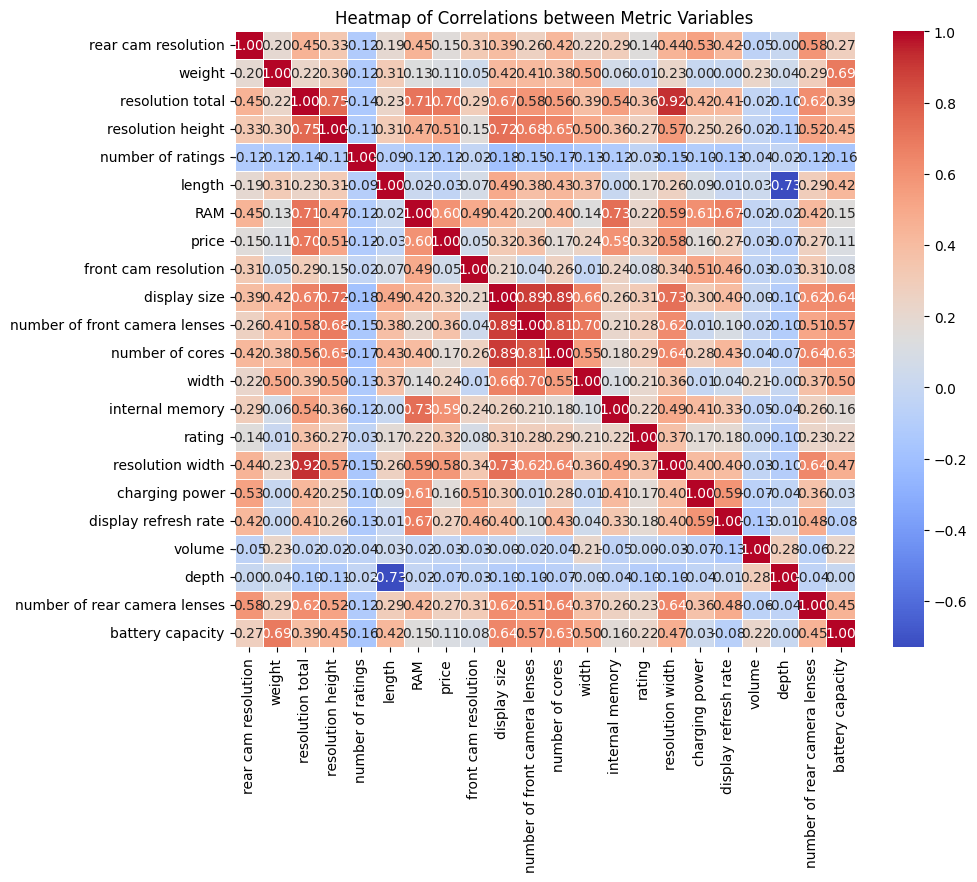

In [13]:
# Plot heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title('Heatmap of Correlations between Metric Variables')

saving_plot("heatmap_corr.png")

### 2. Pre-Processing Variables for Price Model Application

For the modelling process, NA's have to be removed, categorical variables have to be one-hot encoded and boolean variables to be converted into 0/1 variables. Thereby, the models can make use of a great variety of variables. Some variables that clearly show some multicollinearity are removed.

In [11]:
# Data is prepared for modelling. Categorical variables are One-hot encoded, boolean variables converted to 0/1 variables and NA's removed.
float_variables_to_exclude = ['rating', 'resolution width', 'resolution height']
integer_variables_to_exclude = ['ID', 'number of ratings']
categorical_variables_to_exclude = ['configuration cards', 'title', 'processor model']

model_data = generate_model_dataset(data, integer_variables_to_exclude, float_variables_to_exclude, categorical_variables_to_exclude)

`sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.


### 3. Price Modelling

#### 3.1 Generalized Additive Model

Generalized Additive Regression Model (GAM's) - InterpretMLs explainable boosting machines are estimated. As the dependent variable the log price is used. After estimating the model the Shapley values are analyzed.

In [12]:
# Defining modelling variables
y = model_data['price']
# Log-transform the target variable y
y_log = pd.Series(np.log(y), name='log_price')
X = model_data.drop(columns = ['price'])

# Sampling 100 obs for use as the background distribution
X100 = shap.utils.sample(X, 100) 

# Fitting GAM
model_ebm = interpret.glassbox.ExplainableBoostingRegressor(interactions=0)
model_ebm.fit(X, y_log)

# explain the GAM model with SHAP
explainer_ebm = shap.Explainer(model_ebm.predict, X100)
shap_values_ebm = explainer_ebm(X)

PermutationExplainer explainer: 1122it [02:07,  8.44it/s]                          


The partial dependence plot is generated for the total resolution and the Shapley value for the data point 40 is shown: Calculation of SHAP Value, as difference between partial dependence plot (at the feature's values) and expected model output (average of predicted prices). Further the SHAP values for all data points are shown in a scatter plot.

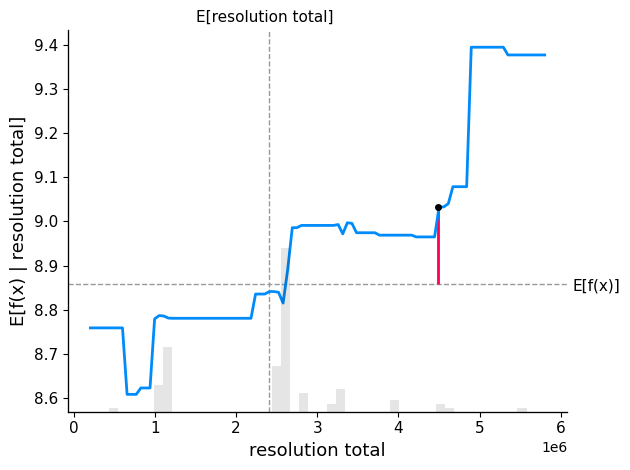

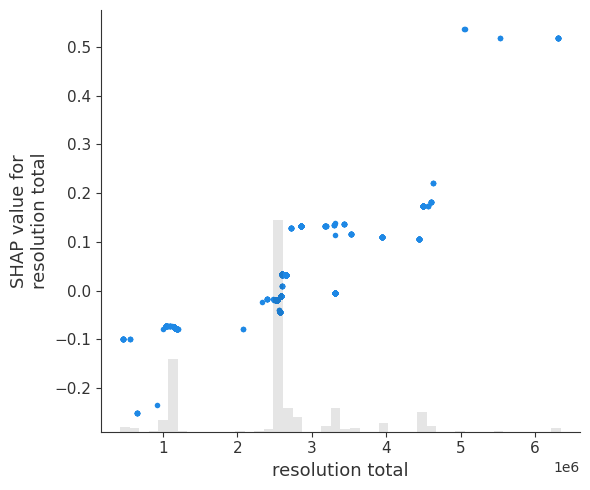

In [90]:
plt.close()
# make a standard partial dependence plot with a single SHAP value overlaid
sample_ind = 40
fig, ax = shap.partial_dependence_plot(
    "resolution total",
    model_ebm.predict,
    X100,
    model_expected_value=True,
    feature_expected_value=True,
    show=False,
    ice=False,
    shap_values=shap_values_ebm[sample_ind : sample_ind + 1, :],
)
# Adjusting layout
plt.tight_layout()
saving_plot("GAM_partial_dep_plot.png")
# Create SHAP value scatter plot
shap.plots.scatter(shap_values_ebm[:, "resolution total"], show=False)
# Adjusting layout
plt.tight_layout()
# Save the plot as a PNG file
saving_plot("GAM_shap_scatter_plot_resolution_total.png")
plt.show()

For the certain data point the 20 highest Shapley values are shown in order. Thereby, it can be interpreted which variables drive the variation in the prices the most for this phone.

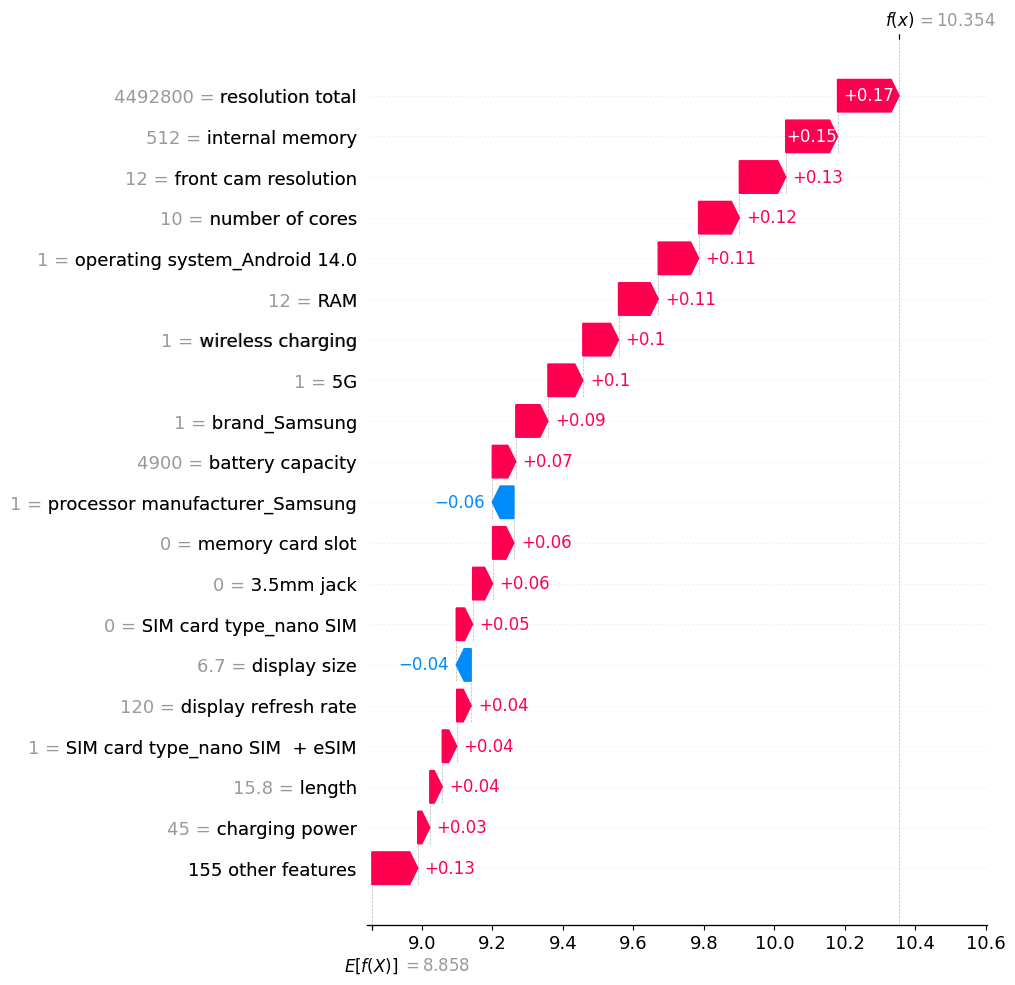

In [91]:
# Close plot before to clean settings
plt.close()
# Plot waterfall plot for Shapley values for one data point
shap.plots.waterfall(shap_values_ebm[40], max_display=20)
plt.tight_layout()
# Closing the plot. Plot can only be safed when "show=False".
plt.close()
shap.plots.waterfall(shap_values_ebm[40], max_display=20, show=False)
# Adjusting layout
plt.tight_layout()
#plt.subplots_adjust(left=0.5, right=0.9, top=0.9, bottom=0.1, wspace=0.5, hspace=1)
saving_plot("GAM_shap_waterfall_plot.png")

In the next step the distribution of the Shapley values across all data points/phones is shown.

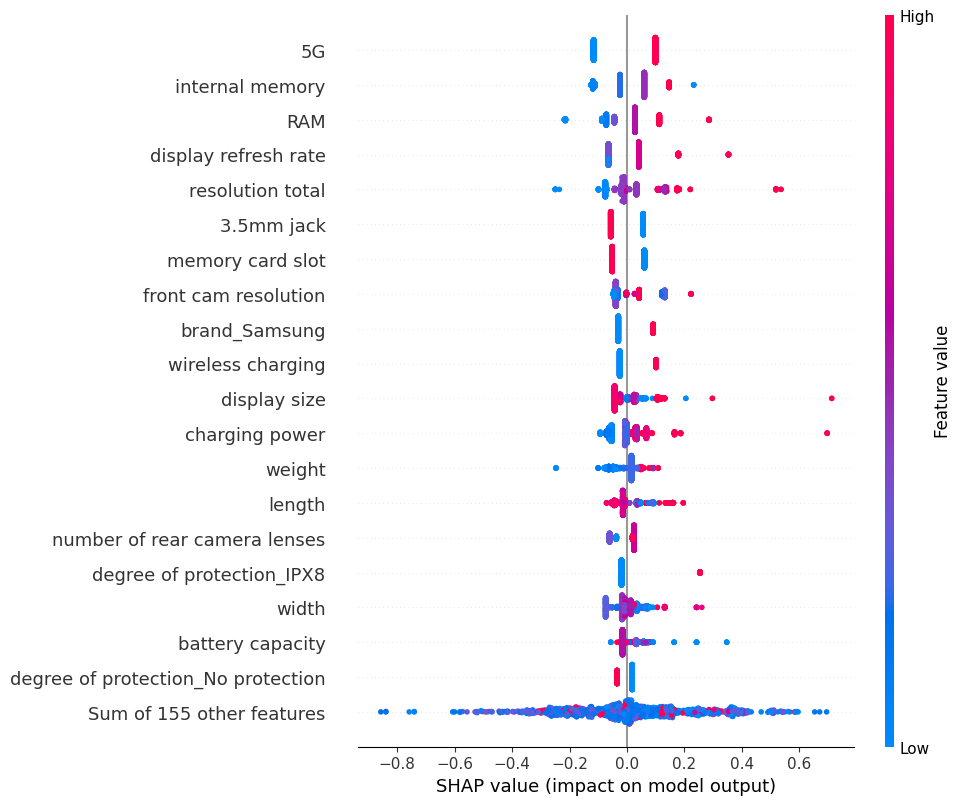

In [92]:
# Close plot before to clean settings
plt.close()
# Plot waterfall plot for Shapley values distribution
shap.plots.beeswarm(shap_values_ebm, max_display = 20)
# Closing the plot. Plot can only be safed when "show=False".
plt.close()
shap.plots.beeswarm(shap_values_ebm, max_display = 20, show=False)
# Adjusting layout
plt.tight_layout()
#plt.subplots_adjust(left=0.5, right=0.9, top=0.9, bottom=0.1, wspace=0.5, hspace=1)
saving_plot("GAM_shap_waterfall_distr_plot.png")

Instead of investigating the usual distribution of Shapley values, the distribution of the absolute Shapley values can be investigated.

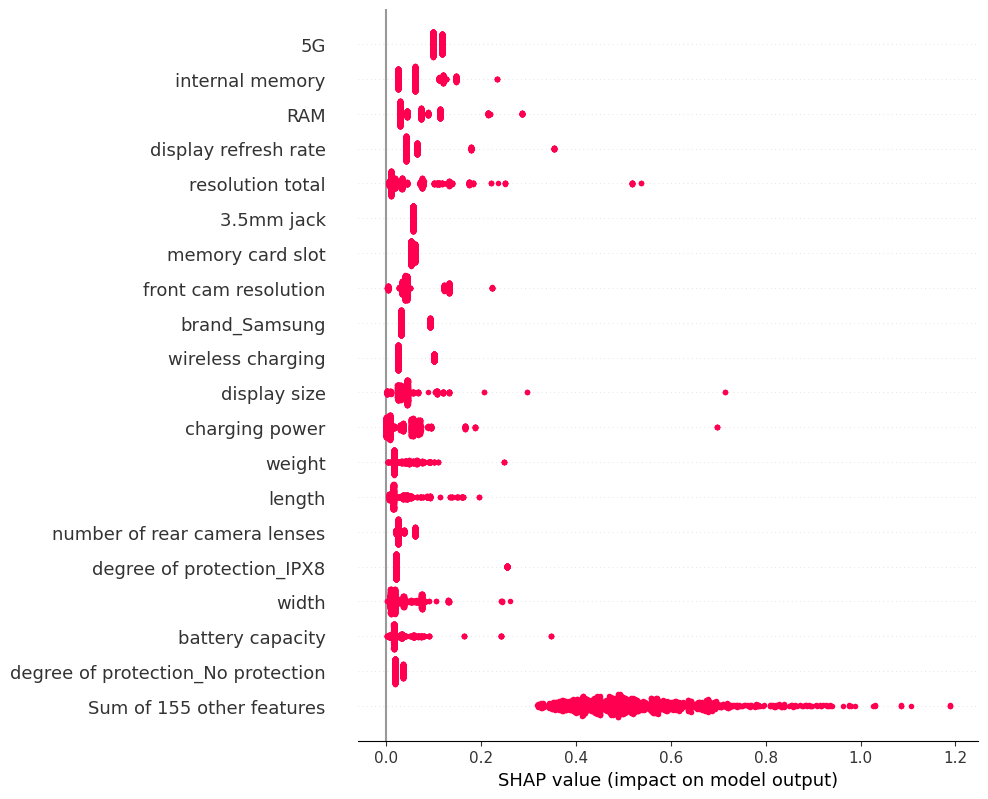

In [93]:
# Close plot before to clean settings
plt.close()
# Plot beeswarm plot for distribution of absolute Shapley values
shap.plots.beeswarm(shap_values_ebm.abs, color="shap_red", max_display = 20)
# Closing the plot. Plot can only be safed when "show=False".
plt.close()
shap.plots.beeswarm(shap_values_ebm.abs, color="shap_red", max_display = 20, show=False)
# Adjusting layout
plt.tight_layout()
saving_plot("GAM_shap_waterfall_abs_plot.png")

As a summary statistic the mean Shapley value across all data points/phones for each feature can be estimated.

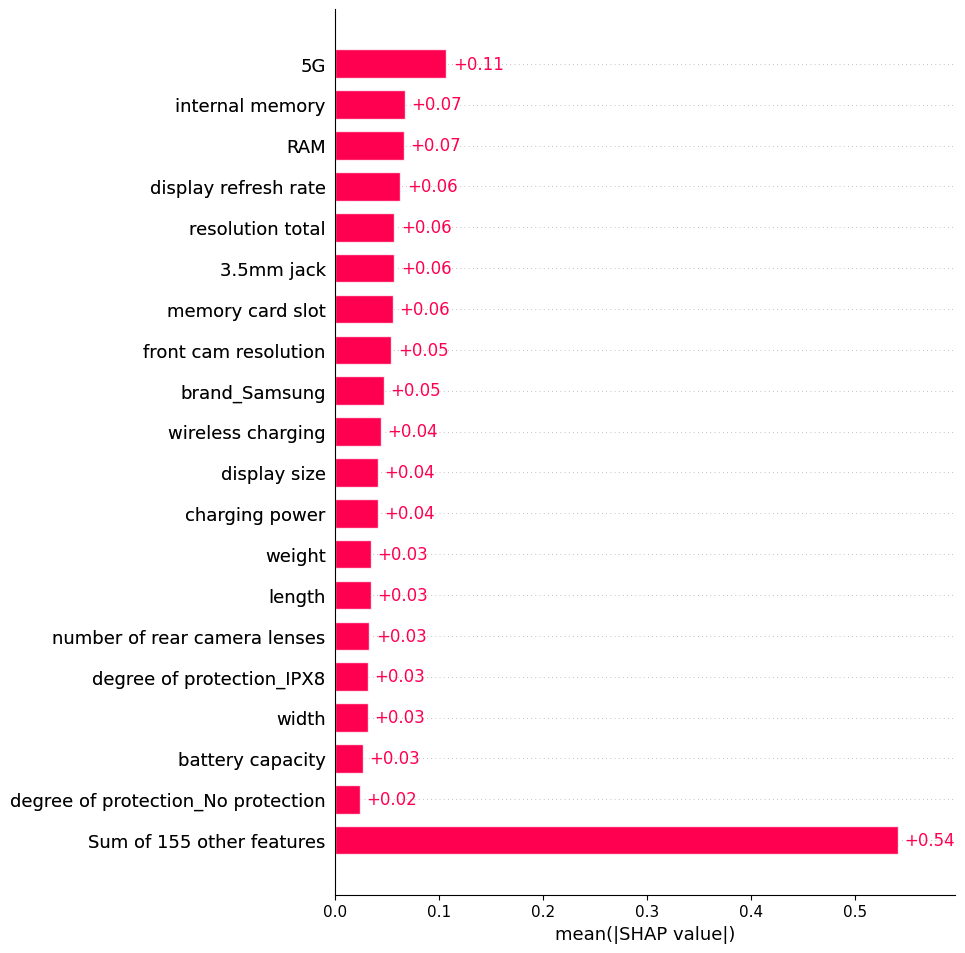

In [94]:
plt.close()
# Plot waterfall plot for mean absolute Shapley values 
shap.plots.bar(shap_values_ebm, max_display = 20)
# Adjusting layout
plt.tight_layout()
# Closing the plot. Plot can only be safed when "show=False".
plt.close()
shap.plots.bar(shap_values_ebm, max_display = 20, show=False)
# Adjusting layout
plt.tight_layout()
plt.subplots_adjust(left=0.5, right=0.9, top=0.9, bottom=0.1, wspace=0.5, hspace=1)
saving_plot("GAM_shap_waterfall_mean_plot.png")

### 3.2 Non-Additive Boosted Tree-Model

As a comparison a non-additive boosted tree model is estimated and its Shapley values are analyzed.

In [76]:
# Fit non-additive boosted tree model
model_xgb = xgboost.XGBRegressor(n_estimators=10000, max_depth=2).fit(X, y_log)

# explain the GAM model with SHAP
explainer_xgb = shap.Explainer(model_xgb, X100) 
shap_values_xgb = explainer_xgb(X)

100%|===================| 1119/1121 [01:38<00:00]        

The partial dependence plot is generated for the total resolution and the Shapley value for the data point 40 is shown. Further the SHAP values for all data points are shown in a scatter plot.

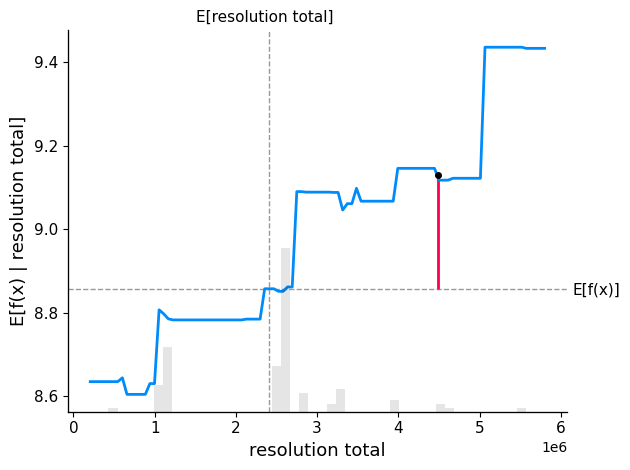

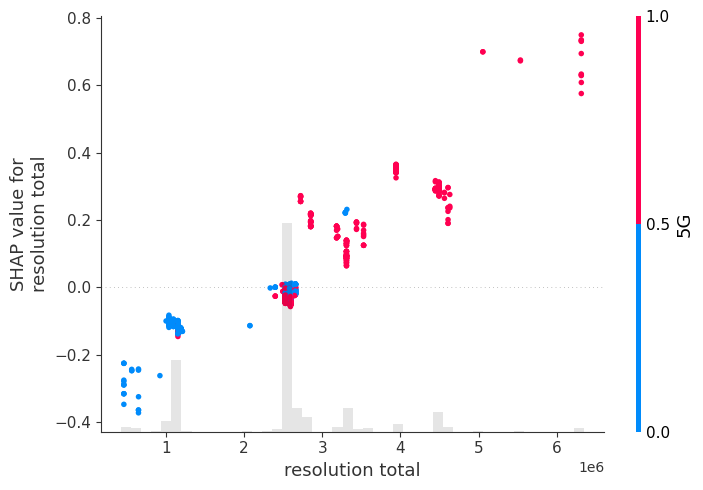

In [95]:
plt.close()
sample_ind = 40
# make a standard partial dependence plot with a single SHAP value overlaid
fig, ax = shap.partial_dependence_plot(
    "resolution total",
    model_xgb.predict,
    X100, 
    model_expected_value=True,
    feature_expected_value=True,
    show=False,
    ice=False,
    shap_values=shap_values_xgb[sample_ind : sample_ind + 1, :],
)
# Adjusting layout
plt.tight_layout()
saving_plot("Non_Add_Boosted_Tree_Model_part_dep_plot.png")

# Plot the Shapley values
shap.plots.scatter(shap_values_xgb[:, 'resolution total'], shap_values_xgb[:, "5G"], show=False)
# Adjusting layout
plt.tight_layout()
saving_plot(f"Non_Add_Boosted_Tree_Model_shap_resolution_total.png")
plt.show()

For the certain data point the 20 highest Shapley values are shown in order. Thereby, it can be interpreted which variables drive the most the variation in the price for this phone.

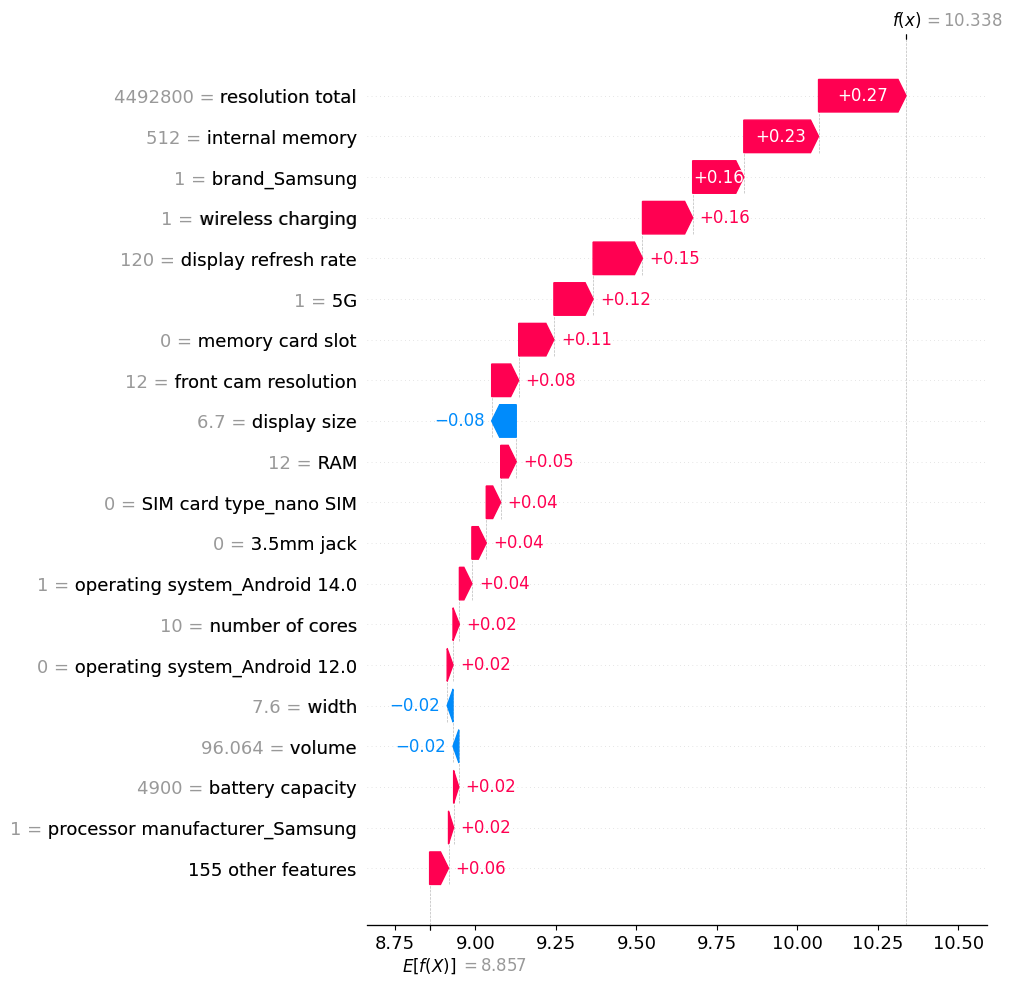

In [96]:
plt.close()
# Plot beeswarm plot for Shapley values distribution
shap.plots.waterfall(shap_values_xgb[40], max_display=20)
# Adjusting layout
plt.tight_layout()
# Closing the plot. Plot can only be safed when "show=False".
plt.close()
shap.plots.waterfall(shap_values_xgb[40], max_display=20, show=False)
# Adjusting layout
plt.tight_layout()
saving_plot(f"Non_Add_Boosted_Tree_Model_shap_plot.png")

Again, the distribution of the Shapley values across all data points/phones is shown next.

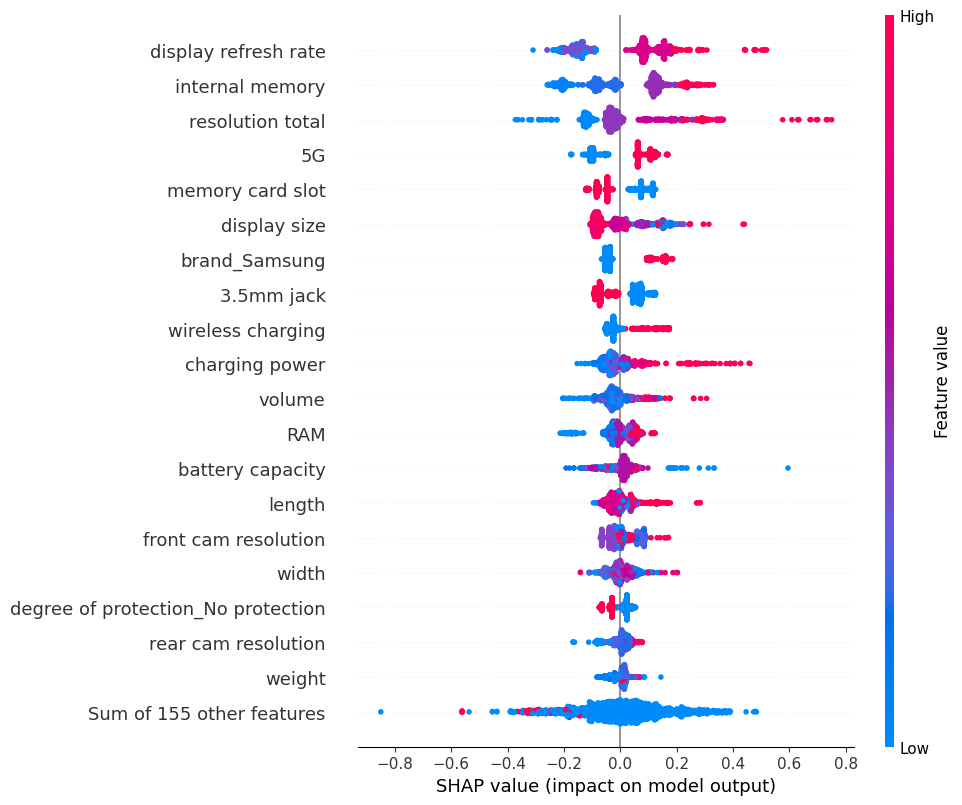

In [97]:
plt.close()
# Plot beeswarm plot for Shapley values distribution
shap.plots.beeswarm(shap_values_xgb, max_display = 20)
# Adjusting layout
plt.tight_layout()
# Closing the plot. Plot can only be safed when "show=False".
plt.close()
shap.plots.beeswarm(shap_values_xgb, max_display = 20, show=False)
# Adjusting layout
plt.tight_layout()
saving_plot(f"Non_Add_Boosted_Tree_Model_shap_waterfall_distr.png")

The distribution of the absolute Shapley values per feature is plotted next.

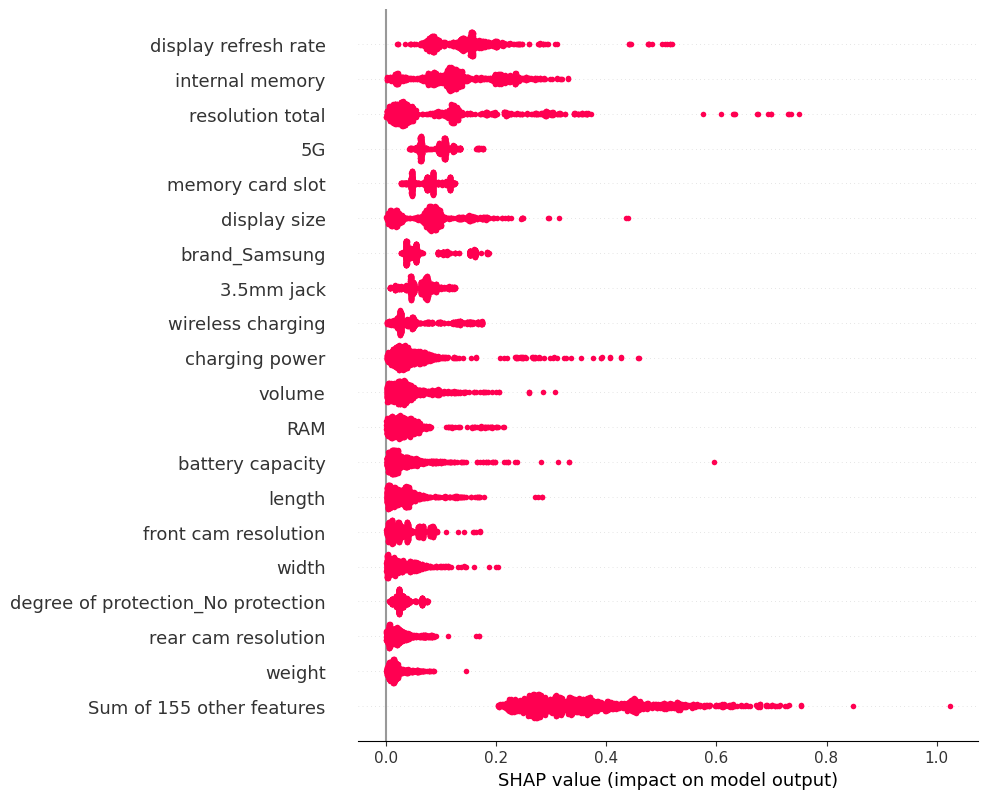

In [98]:
plt.close()
# Plot beeswarm plot for absolute Shapley values distribution
shap.plots.beeswarm(shap_values_xgb.abs, color="shap_red", max_display = 20)
# Adjusting layout
plt.tight_layout()
# Closing the plot. Plot can only be safed when "show=False".
plt.close()
shap.plots.beeswarm(shap_values_xgb.abs, color="shap_red", max_display = 20, show=False)
# Adjusting layout
plt.tight_layout()
saving_plot(f"Non_Add_Boosted_Tree_Model_shap_waterfall_abs_distr.png")

Finally, the waterfall plot with the mean absolute Shapley value across all data points/phones is plotted. The 20 features with the highest Shapley values are shown.

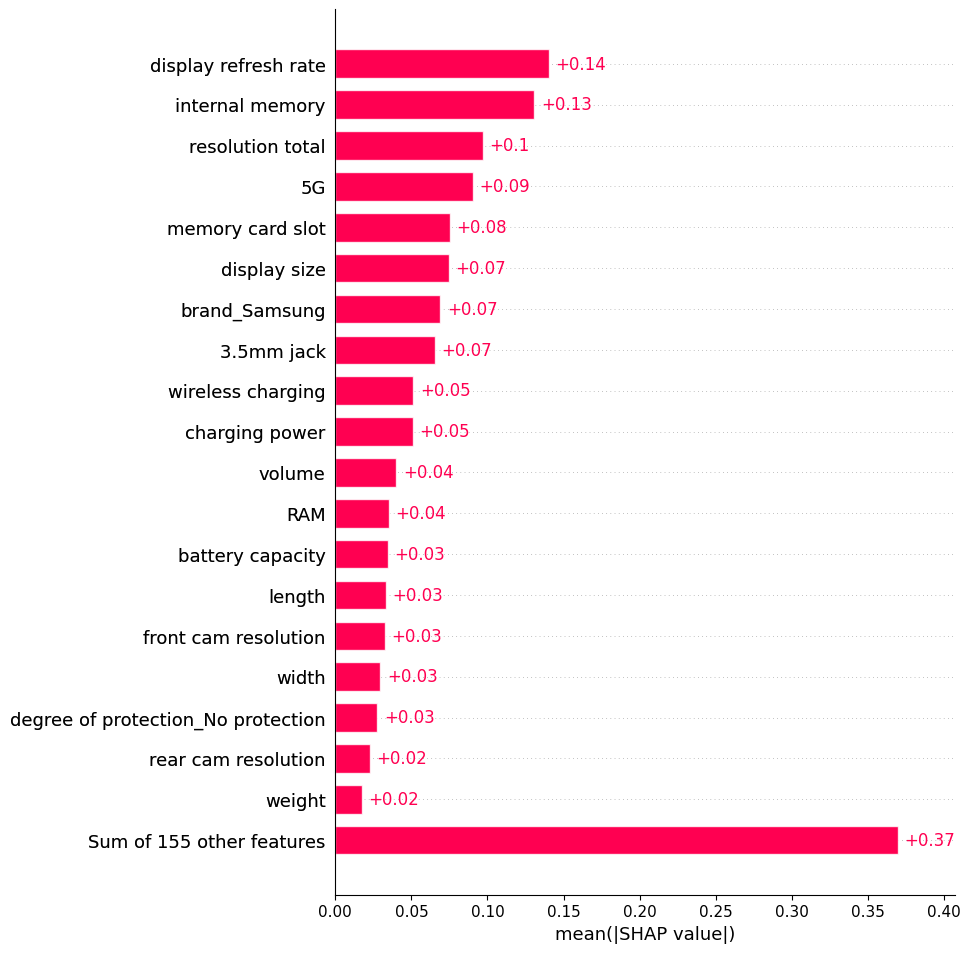

In [99]:
plt.close()
# Plot waterfall plot for mean absolute Shapley values 
shap.plots.bar(shap_values_xgb, max_display = 20)
# Adjusting layout
plt.tight_layout()
# Closing the plot. Plot can only be safed when "show=False".
plt.close()
shap.plots.bar(shap_values_xgb, max_display = 20, show=False)
# Adjusting layout
plt.tight_layout()
saving_plot(f"Non_Add_Boosted_Tree_Model_shap_waterfall_mean.png")